<a href="https://colab.research.google.com/github/sidnet1964/cashback/blob/master/model_analysis/visualize_decision_trees_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization of CatBoost decision trees tutorial

In [9]:
import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

#### Load boston dataset from sklearn

In [10]:
# from sklearn.datasets import load_boston
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()

In [11]:
# boston = load_boston()
# y = boston['target']
# X = boston['data']

In [12]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [13]:
pool = catboost.Pool(
    data=X,
    label=y
)

Create and fit CatBoost model with trees of depth 2.

In [14]:
model = CatBoostRegressor(depth=2, verbose=False, iterations=1).fit(X, y)

Currently only symmetric trees can be visualized.

Let's consider symmetric decision tree. In such tree only one feature is used to build all splits at each tree level. There are three types of splits: "FloatFeature", "OneHotFeature" and "OnlineCtr". Model without categorical features contains only "FloatFeature" splits.

In visualised tree each node represents one split. Since there are three types of splits there are three types of tree nodes.

#### FloatFeature
Let's look at the first tree of our model.

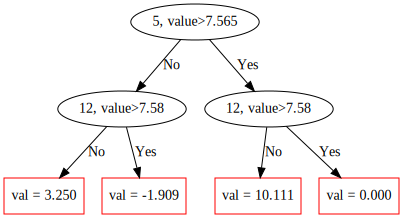

In [15]:
model.plot_tree(
    tree_idx=0,
    # pool=pool,
)

Our model doesn't have categorical features, so there are only "FloatFeature" nodes in visualised tree.
Node corresponding to "FloatFeature" split contains feature index and border value, which are used to split objects.

In this example, the node of depth 0 shows that objects are splitted by their 0th feature with border value $393.795$. Analogously, nodes of depth 1 split objects by their 2nd feature with border value $279.5$.

"pool" parameter is optional for models without one hot features. Features are labeled with their external indexes from pool or features names if pool is provided, otherwise internal indexes are used. For semicolon-separated pool with 2 features  "f1;label;f2" external feature indexes are 0 and 2, internal indexes are 0 and 1 respectively.

#### OneHotFeature

We will use `catboost.datasets.titanic` dataset, which contains categorical data.

In [16]:
from catboost.datasets import titanic
titanic_df = titanic()

X = titanic_df[0].drop('Survived',axis=1)
y = titanic_df[0].Survived

In [17]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Processing NaN values in categorical features.

In [18]:
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]

<ipython-input-18-1bfe39a210a2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[feature].fillna("NAN", inplace=True)


In [19]:
pool = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))

Define and fit CatBoost model

In [20]:
model = CatBoostClassifier(
    max_depth=2, verbose=False, max_ctr_complexity=1, random_seed=42, iterations=2).fit(pool)


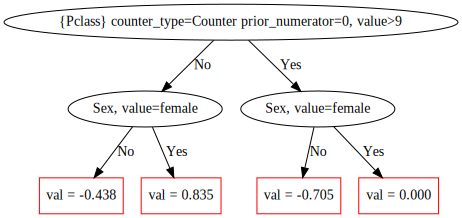

In [21]:
model.plot_tree(
    tree_idx=0,
    pool=pool # "pool" is required parameter for trees with one hot features
)

The first tree contains only one split made by "OneHotFeature" `Sex`. This split puts objects with `Sex=female` to the left and other objects to the right.

#### OnlineCtr features

Let's look at other trees, which contain "OnlineCtr" splits.

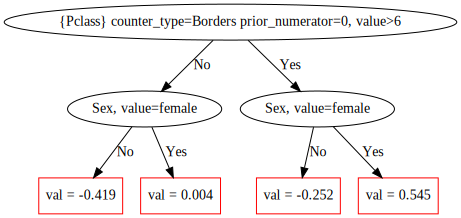

In [22]:
model.plot_tree(tree_idx=1, pool=pool)

The node of depth 0 corresponds to "OnlineCtr" split. This split is made by one feature `Pclass`.